In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
abbreviations = ['sss', 'ses', 'crc', 'mm16f', 'fft', 'cjpeg', 'str', 'qsort', 'mm16i', 'dijk', 'mm32i', 'sel', 'avg']
name_map = {
    'cjpeg.csv': 'cjpeg',
    'cjpeg.nocache.csv': 'cjpeg',
    'dijkstra.csv': 'dijk',
    'fft.csv': 'fft',
    'matmul_float_16.csv': 'mm16f',
    'matmul_int_32.csv': 'mm32i',
    'matmul_int_16.csv': 'mm16i',
    'matmul16_float.csv': 'mm16f',
    'matmul16_int.csv': 'mm16i',
    'matmul32_int.csv': 'mm32i',
    'qsort.csv': 'qsort',
    'qsort_small.csv': 'qsort',
    'str_search.csv': 'str',
    'search_large.csv': 'str',
    'susan_edge_large.csv': 'sel',
    'susan_edge_small.csv': 'ses',
    'susan_smooth_small.csv': 'sss',
    'average': 'avg'
}

# Single Trace

## Load trace

In [3]:
np.random.seed(0)
col_names = ['cycle', 'op', 'width', 'addr']
df = pd.read_csv('../traces/fft.csv', names=col_names)
df.head()

cycle  op  width    addr
0     30  ST      8  158415
1     32  ST      8  158414
2     34  ST      8  158413
3     36  ST      8  158412
4     55  ST     32  158416

### Add Blocks

In [4]:
block_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512] # number of 32bit words
for bs in block_sizes:
    shift_val = int(np.log2(bs*4)) 
    df[f'block_{bs}'] = np.right_shift(df.addr & 0xffffffff, shift_val)

In [5]:
mem_word = len(df.block_1.unique())
mem_page_512 = len(df.block_128.unique())*128
mem_page_1K = len(df.block_256.unique())*256 
mem_page_2K = len(df.block_512.unique())*512

### Count load and stores

In [6]:
ops = df.op.value_counts()
ops

LD    4147958
ST    3546190
Name: op, dtype: int64

In [7]:
ops['LD']

4147958

## Energy Cost estimation

Using 1 for SRAM read and write and NVM read energy cost, 100 for NVM write energy cost

In [8]:
E_sram_w, E_sram_r  = 1, 1
E_nvm_w = 100 * E_sram_w
E_nvm_r = 1 * E_sram_r
E_nvm = E_nvm_w * ops['ST'] + E_nvm_r * ops['LD']
E_sram_prog = E_sram_w * ops['ST'] + E_sram_r * ops['LD']

### Divide trace in intervals with randomly distributed power failures

In [9]:
pwr_fail_per_cycle = 1e-6
prog_cycles = df.cycle.iloc[-1]
events = np.random.choice([0, 1], size = prog_cycles, replace=True, p=[1-pwr_fail_per_cycle, pwr_fail_per_cycle])
pwr_fail_times = np.where(events==1)[0]
len(pwr_fail_times)

49

In [10]:
n = np.random.poisson(pwr_fail_per_cycle * prog_cycles)
ts = np.cumsum(np.random.geometric(pwr_fail_per_cycle, n))
len(ts)

64

In [11]:
df['iv'] = 0
for t in ts:
    df['iv'] += t < df.cycle

In [12]:
df.iv.nunique()

64

In [13]:
df['interval'] = 0
for t in pwr_fail_times:
    df['interval'] += t < df.cycle

### Compute Freezer backup size (Modified block 8)

In [14]:
by_interval = df[['block_8', 'op', 'interval']].groupby('interval')
modified_in_interval = by_interval.apply(lambda g: g[(g.op == 'ST')].block_8.nunique()) * 8

### Estimate Energy costs

In [15]:
E_backup = modified_in_interval.sum() * (E_nvm_w + E_sram_r)
E_restore = mem_page_512 * (E_nvm_r + E_sram_w)

In [16]:
E_sram = E_sram_prog + E_backup + E_restore

In [17]:
E_sram

9028092

In [18]:
E_nvm

358766958

In [19]:
def energy_sram(st, ld, sram_size, modified_total):
    E_sram_prog = E_sram_w * st + E_sram_r * ld
    E_backup = modified_total * (E_nvm_w + E_sram_r)
    E_restore = sram_size * (E_nvm_r + E_sram_w)
    return E_sram_prog + E_backup + E_restore

In [20]:
def add_intervals(df, pwr_fail_per_cycle = 1e-6):
    prog_cycles = ops.sum()
    events = np.random.choice([0, 1], size = prog_cycles, replace=True, p=[1-pwr_fail_per_cycle, pwr_fail_per_cycle])
    pwr_fail_times = np.where(events==1)[0]
    df['interval'] = 0
    for t in pwr_fail_times:
        df['interval'] += t < df.cycle

# Multi trace

### Load dataframe with energy cost per interval

In [21]:
iv_df = pd.read_csv('../res/random_intervals/poisson_1e-6_iv_100-executions.csv', index_col='trace')

### Load dataframe with nuber of memory operations

In [22]:
ops_df = pd.read_csv('../res/ops.csv', index_col='trace')

In [23]:
ops_df = ops_df.loc[iv_df.num_interval_avg > 2]
ops_df

LD       ST
trace                                    
susan_smooth_small.csv   5087286   173403
susan_edge_small.csv      752670   125671
matmul_float_16.csv      3219085  2767375
fft.csv                  4147958  3546190
cjpeg.nocache.csv        1240974   564840
search_large.csv          963021   933224
qsort_small.csv          4014411  3036168
dijkstra.csv            12278436  4198167
matmul_int_32.csv         484344   216515
susan_edge_large.csv    18312324  2736819

In [24]:
ops_df['trace'] = ops_df.index.map(name_map)
ops_df = ops_df.reset_index(drop=True).set_index('trace')
ops_df

LD       ST
trace                   
sss     5087286   173403
ses      752670   125671
mm16f   3219085  2767375
fft     4147958  3546190
cjpeg   1240974   564840
str      963021   933224
qsort   4014411  3036168
dijk   12278436  4198167
mm32i    484344   216515
sel    18312324  2736819

### Load energy-cost strategy comparison dataframe

In [25]:
comp_df = pd.read_csv('../res/energy/energy_100nvm_1e-6iv_100_poisson.csv', index_col='trace').loc[iv_df.num_interval_avg > 2].drop('average')
comp_df['trace'] = comp_df.index.map(name_map)
comp_df = comp_df.reset_index(drop=True).set_index('trace')
comp_df

freezer_avg   freezer_std  full_mem_backup_avg  full_mem_backup_std  \
trace                                                                        
sss     6065300.04  2.448354e+04         2.952834e+07         4.300346e+06   
ses     2419060.44  9.165707e+04         9.496001e+06         3.088779e+06   
mm16f   7397855.92  2.414676e+05         1.600095e+07         1.878320e+06   
fft     9446482.48  2.333735e+05         2.788439e+07         2.641307e+06   
cjpeg   3956974.24  4.194604e+05         1.041125e+07         3.023568e+06   
str     2794440.60  1.468030e+05         1.223071e+07         2.987739e+06   
qsort  99328867.56  5.860189e+06         1.035957e+09         2.039704e+08   
dijk   28443529.40  7.970886e+05         1.297747e+08         1.322151e+07   
mm32i    963499.08  5.157642e+04         3.137431e+06         9.697208e+05   
sel    51298428.20  5.934339e+05         2.430034e+09         2.145374e+08   

               NVM  
trace               
sss     22427586.0  
ses     13319770.0  
mm16f  279956585.0  
fft    358766958.0  
cjpeg   57724974.0  
str     94285421.0  
qsort  307631211.0  
dijk   432095136.0  
mm32i   22135844.0  
sel    291994224.0

m

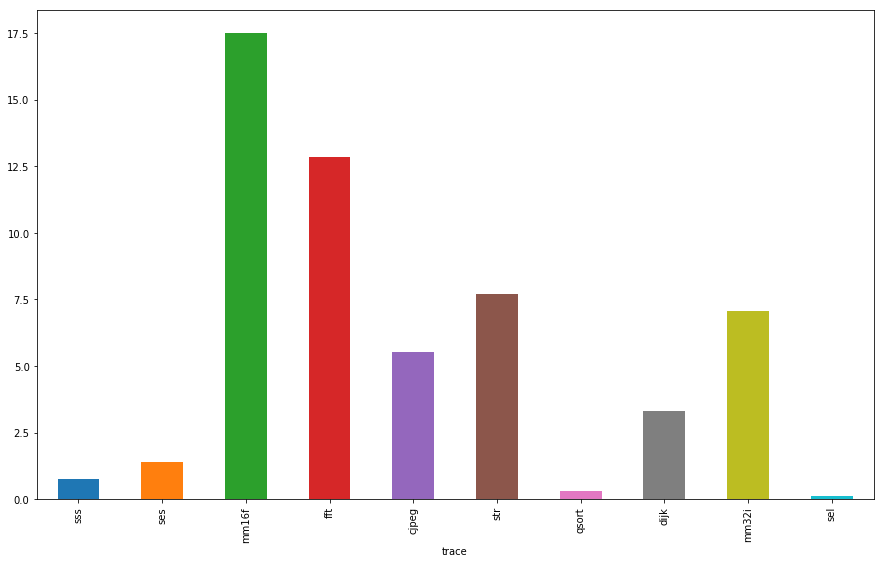

In [26]:
(comp_df.NVM / comp_df.full_mem_backup_avg).plot.bar(figsize=(15,9))

In [27]:
comp_df[['full_mem_backup_avg', 'freezer_avg']].rdiv(comp_df.NVM, axis=0)

full_mem_backup_avg  freezer_avg
trace                                  
sss               0.759527     3.697688
ses               1.402671     5.506175
mm16f            17.496251    37.842936
fft              12.866230    37.978894
cjpeg             5.544479    14.588160
str               7.708909    33.740356
qsort             0.296954     3.097098
dijk              3.329579    15.191333
mm32i             7.055404    22.974432
sel               0.120161     5.692070

### NVM only energy-cost can be more than 35x higher than Freezer 

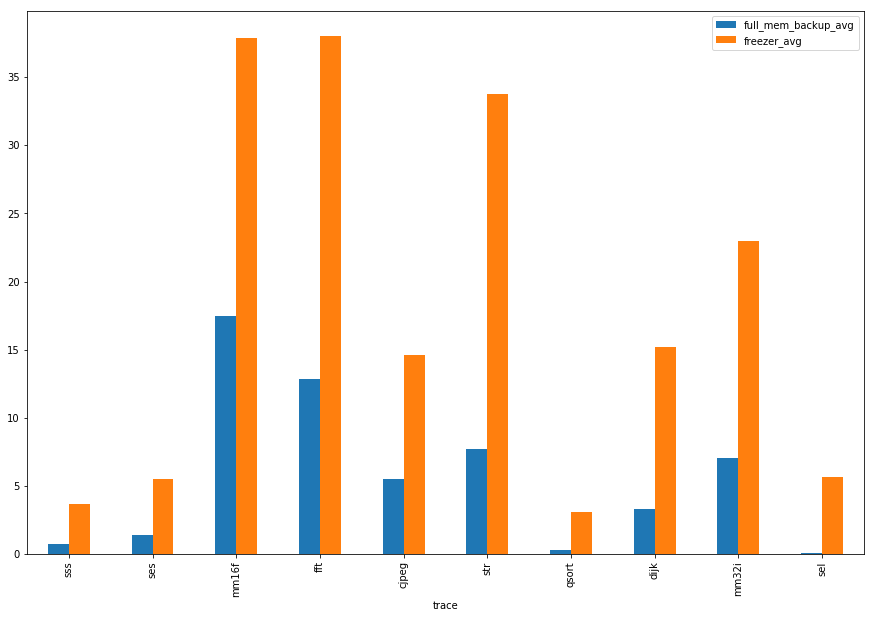

In [28]:
comp_df[['full_mem_backup_avg', 'freezer_avg']].rdiv(comp_df.NVM, axis=0).plot.bar(figsize=(15,10))
# rdiv is reverse division (NVM / freezer) and (NVM / full-mem)

### Energy cost / Number of load and store 

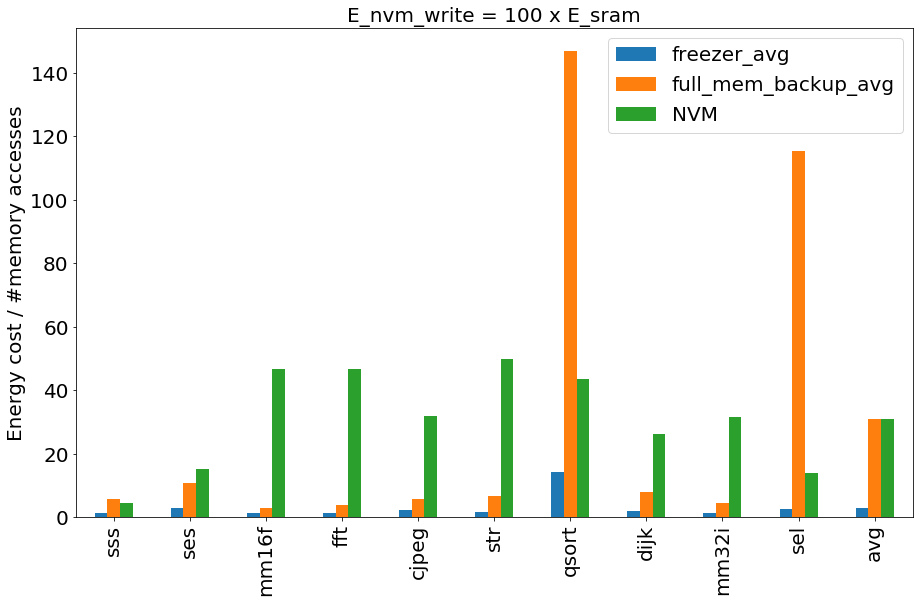

In [29]:
tmp = comp_df[['freezer_avg', 'full_mem_backup_avg', 'NVM']].div(ops_df.ST + ops_df.LD, axis=0)
tmp.loc['avg'] = tmp.mean()
ax = tmp.plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('E_nvm_write = 100 x E_sram', fontsize=20)
ax.set_ylabel('Energy cost / #memory accesses', fontsize=20)
ax.set_xlabel('')
ax.legend(prop={'size':20})

## E_nvm = 10 x E_sram

In [30]:
e10_df = pd.read_csv('../res/energy/energy_10nvm_1e-6iv_100_poisson.csv', index_col='trace').loc[iv_df.num_interval_avg > 2].drop('average')
e10_df['trace'] = e10_df.index.map(name_map)
e10_df = e10_df.reset_index(drop=True).set_index('trace')
e10_df

freezer_avg    freezer_std  full_mem_backup_avg  full_mem_backup_std  \
trace                                                                         
sss     5360866.44    2666.524301         7.916247e+06         4.683545e+05   
ses     1070550.84    9982.452948         1.841307e+06         3.364017e+05   
mm16f   6145423.12   26298.450677         7.082393e+06         2.045695e+05   
fft     7890699.28   25416.918890         9.898788e+06         2.876671e+05   
cjpeg   2059032.64   45683.807184         2.761974e+06         3.292994e+05   
str     2010036.60   15988.446684         3.037749e+06         3.253973e+05   
qsort  17675777.16  638238.392646         1.196848e+08         2.221460e+07   
dijk   17806393.40   86811.628463         2.884246e+07         1.439967e+06   
mm32i    738131.88    5617.233699         9.748968e+05         1.056132e+05   
sel    24644280.20   64631.416978         2.837145e+08         2.336546e+07   

              NVM  
trace              
sss     6821316.0  
ses     2009380.0  
mm16f  30892835.0  
fft    39609858.0  
cjpeg   6889374.0  
str    10295261.0  
qsort  34376091.0  
dijk   54260106.0  
mm32i   2649494.0  
sel    45680514.0

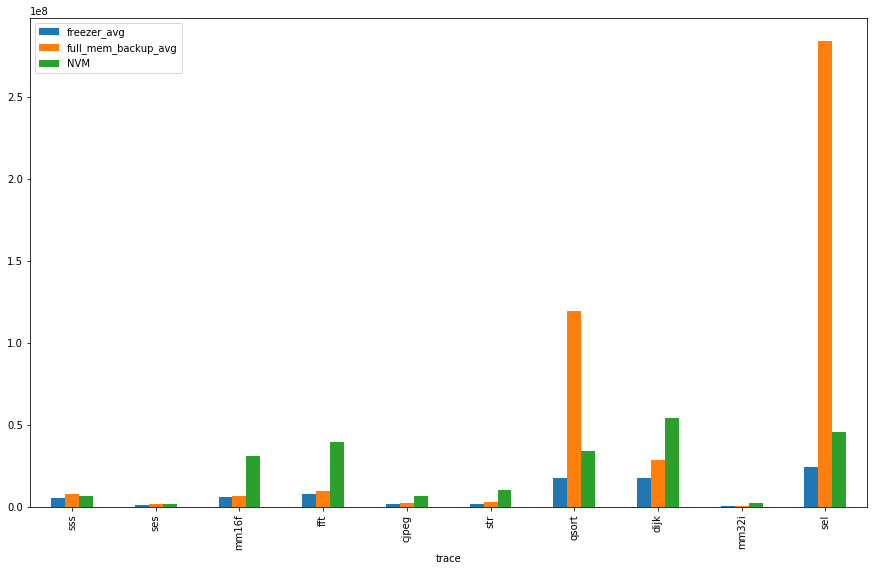

In [31]:
e10_df[['freezer_avg', 'full_mem_backup_avg', 'NVM']].plot.bar(figsize=(15,9))

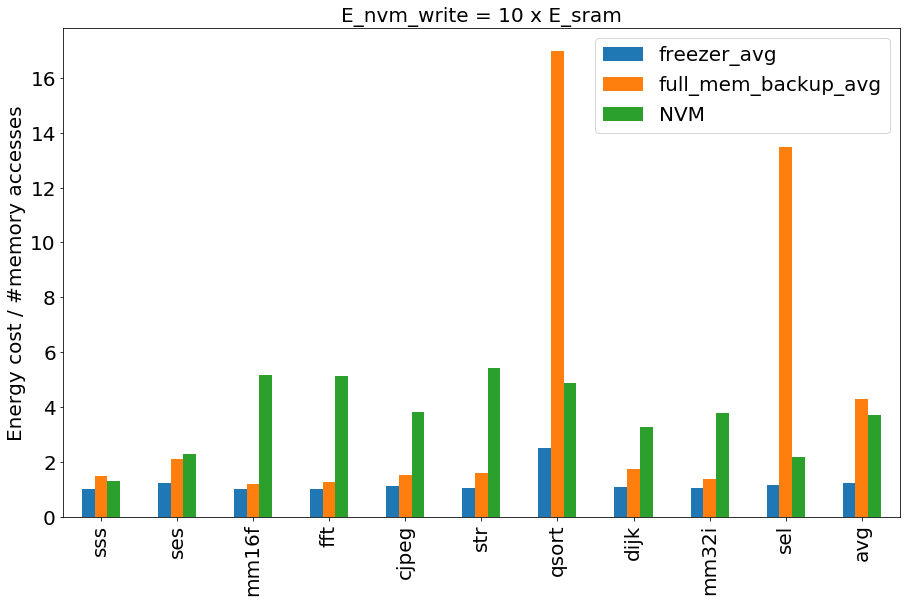

In [32]:
tmp = e10_df[['freezer_avg', 'full_mem_backup_avg', 'NVM']].div(ops_df.LD + ops_df.ST, axis=0)
tmp.loc['avg'] = tmp.mean()
ax = tmp.plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('E_nvm_write = 10 x E_sram', fontsize=20)
ax.set_ylabel('Energy cost / #memory accesses', fontsize=20)
ax.set_xlabel('')
ax.legend(prop={'size':20})

## Cache energy cost

In [33]:
for f in os.listdir('../res/cache_res/cache4096'):
    if f in name_map.keys():
        print(f, name_map[f])

susan_smooth_small.csv sss
susan_edge_small.csv ses
matmul_float_16.csv mm16f
fft.csv fft
cjpeg.nocache.csv cjpeg
search_large.csv str
qsort_small.csv qsort
matmul_int_16.csv mm16i
dijkstra.csv dijk
matmul_int_32.csv mm32i
susan_edge_large.csv sel


In [34]:
cache_df = pd.read_csv('../res/cache_res/cache4096/fft.csv')
cache_df

interval  evicts  flushes  mem_wr  read_hits  read_misses  stores  \
0         0       1       40      41     460502           32  406678   
1         1       0       22      22     455598           31  402012   
2         2      48       74     122     459647           84  405189   
3         3     295       79     374     872517          280  733635   
4         4     292       73     365     873602          262  735065   
5         5     256       76     332     870519          256  733470   
6         6      65       66     131     154528          100  130141   

   write_hits  write_misses  
0      406640            38  
1      401995            17  
2      405103            86  
3      733512           123  
4      734926           139  
5      733355           115  
6      130087            54

In [35]:
cache_df['hits'] = cache_df.read_hits + cache_df.write_hits
cache_df['misses'] = cache_df.read_misses + cache_df.write_misses

In [36]:
cache_df.mem_wr.sum()*100 + cache_df.hits.sum()*3

23216293

In [37]:
comp_df.loc['fft']['freezer_avg'] < (cache_df.mem_wr.sum()*100 + cache_df.hits.sum()*3)

True

In [38]:
def cache_energy(cache_df, E_nvm_w=100, E_rd=3):
    return (cache_df.mem_wr.sum() * E_nvm_w + (cache_df.misses.sum() + cache_df.hits.sum()) * E_rd )

In [39]:
def build_cache_en_df(dir):
    cache_en = []
    cache_en10 = []
    for f in os.listdir(dir):
        if f in name_map.keys():
            cache_df = pd.read_csv(f'{dir}/{f}')
            cache_df['hits'] = cache_df.read_hits + cache_df.write_hits
            cache_df['misses'] = cache_df.read_misses + cache_df.write_misses
            cache_en.append((name_map[f], cache_energy(cache_df)))
            cache_en10.append((name_map[f], cache_energy(cache_df, E_nvm_w=10)))
    return cache_en, cache_en10

In [40]:
%ls ../res/cache_res/

cache1024/  cache16384/  cache2048/  cache32768/  cache4096/  cache8192/


In [41]:
c, c10 = build_cache_en_df('../res/cache_res/cache4096')
comp_df['cache4k'] = comp_df.index.map(dict(c))
e10_df['cache4k'] = e10_df.index.map(dict(c10))

In [42]:
c, c10 = build_cache_en_df('../res/cache_res/cache2048')
comp_df['cache2k'] = comp_df.index.map(dict(c))
e10_df['cache2k'] = e10_df.index.map(dict(c10))

c, c10 = build_cache_en_df('../res/cache_res/cache8192')
comp_df['cache8k'] = comp_df.index.map(dict(c))
e10_df['cache8k'] = e10_df.index.map(dict(c10))

c, c10 = build_cache_en_df('../res/cache_res/cache16384')
comp_df['cache16k'] = comp_df.index.map(dict(c))
e10_df['cache16k'] = e10_df.index.map(dict(c10))
comp_df

freezer_avg   freezer_std  full_mem_backup_avg  full_mem_backup_std  \
trace                                                                        
sss     6065300.04  2.448354e+04         2.952834e+07         4.300346e+06   
ses     2419060.44  9.165707e+04         9.496001e+06         3.088779e+06   
mm16f   7397855.92  2.414676e+05         1.600095e+07         1.878320e+06   
fft     9446482.48  2.333735e+05         2.788439e+07         2.641307e+06   
cjpeg   3956974.24  4.194604e+05         1.041125e+07         3.023568e+06   
str     2794440.60  1.468030e+05         1.223071e+07         2.987739e+06   
qsort  99328867.56  5.860189e+06         1.035957e+09         2.039704e+08   
dijk   28443529.40  7.970886e+05         1.297747e+08         1.322151e+07   
mm32i    963499.08  5.157642e+04         3.137431e+06         9.697208e+05   
sel    51298428.20  5.934339e+05         2.430034e+09         2.145374e+08   

               NVM    cache4k    cache2k   cache8k  cache16k  
trace                                                         
sss     22427586.0   16038167   16589667  15921167  15878467  
ses     13319770.0    3083823    3238723   3026123   2943723  
mm16f  279956585.0   18023380   19140680  17988180  17987880  
fft    358766958.0   23221144   24052544  23131444  23130144  
cjpeg   57724974.0   20387442   25809842  10147142   6605042  
str     94285421.0    6197635    9454035   5886535   5802435  
qsort  307631211.0   48915937   51761037  46400337  43881737  
dijk   432095136.0  148694609  221024209  85964209  69930609  
mm32i   22135844.0    2614077    5494277   2165277   2120877  
sel    291994224.0   77051729   91640629  72609329  70685029

In [43]:
cmp_list = ['freezer_avg', 'full_mem_backup_avg', 'NVM', 'cache16k', 'cache8k', 'cache4k']

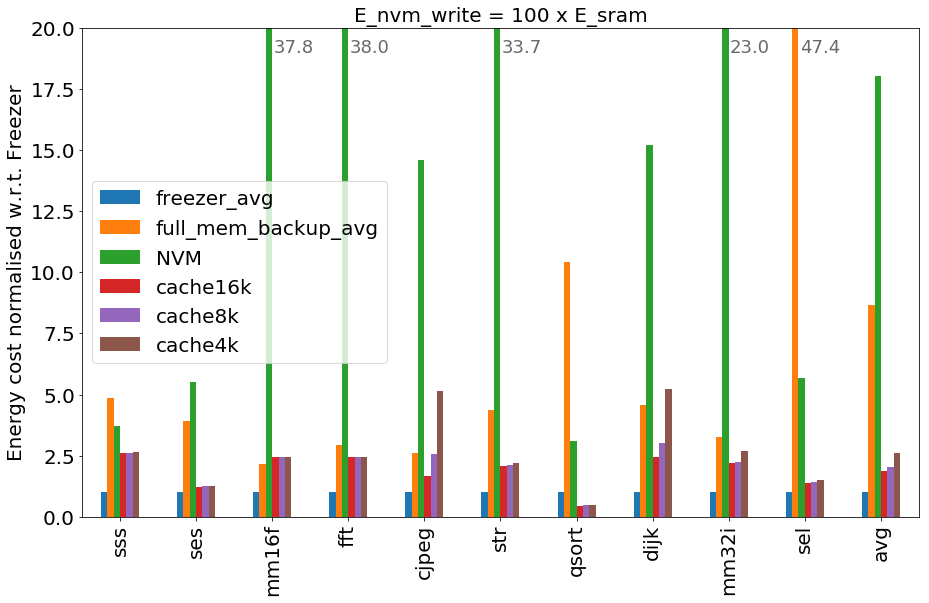

In [44]:
tmp = comp_df[cmp_list].div(comp_df.freezer_avg, axis=0)#(ops_df.ST + ops_df.LD, axis=0)
tmp.loc['avg'] = tmp.mean()
ax = tmp.plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('E_nvm_write = 100 x E_sram', fontsize=20)
ax.set_ylabel('Energy cost normalised w.r.t. Freezer', fontsize=20)
ax.set_xlabel('')
ax.set_ylim([0,20])
ax.legend(prop={'size':20}, loc='center left')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down i.get_height()+
    if i.get_height() > 20:
        ax.text(i.get_x()+.1, 19, \
            str(round(i.get_height(),1)), fontsize=18, color='dimgrey')

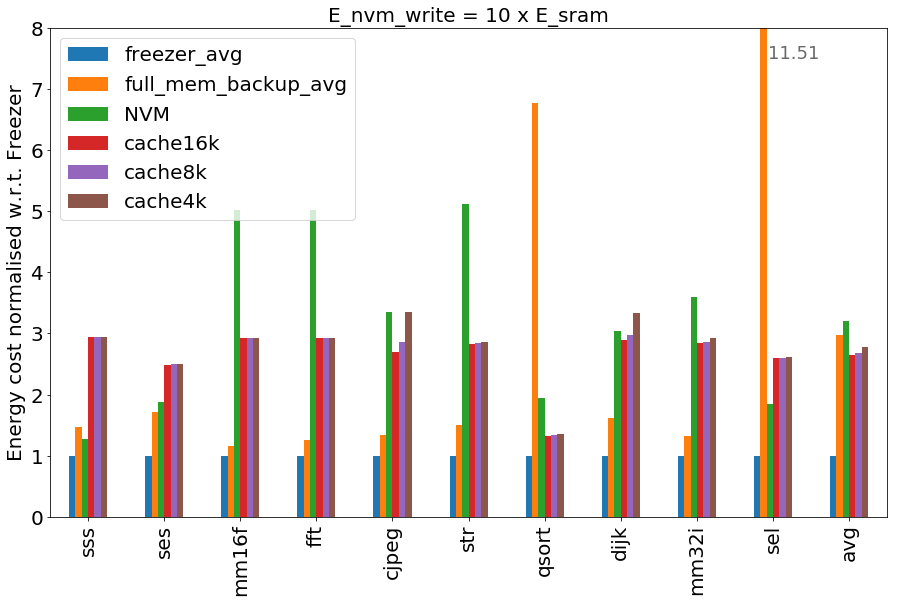

In [45]:
tmp = e10_df[cmp_list].div(e10_df.freezer_avg, axis=0)#(ops_df.LD + ops_df.ST, axis=0)
tmp.loc['avg'] = tmp.mean()
ax = tmp.plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('E_nvm_write = 10 x E_sram', fontsize=20)
ax.set_ylabel('Energy cost normalised w.r.t. Freezer', fontsize=20)
ax.legend(prop={'size':20}, loc='upper left')
ax.set_xlabel('')
ax.set_ylim([0,8])


for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down i.get_height()+
    if i.get_height() > 8:
        ax.text(i.get_x()+.1, 7.5, \
            str(round(i.get_height(),2)), fontsize=18, color='dimgrey')

---
# Analysis With NVSim data

In [46]:
comp_cols = ['E_freezer_{}', 'E_full_memory_{}', 'E_{}_only', 'E_cache2k_{}', 'E_cache4k_{}', 'E_cache8k_{}', 'E_cache16k_{}']
cache_names = {f'E_cache{size*1024}_{nvm}': f'E_cache{size}k_{nvm}' for nvm in ['stt', 'stt_aggressive', 'rram']  for size in [2,4,8,16]}

In [47]:
comp_df = pd.read_csv('../res/energy/energy_1e-6iv.csv', index_col=0)
comp_df['Trace'] = comp_df.index.map(name_map)
comp_df = comp_df.reset_index(drop=True).set_index('Trace')
comp_df.rename(columns=cache_names, inplace=True)
comp_df

freezer_avg_backup_size  freezer_tot_backup_size  num_intervals  \
Trace                                                                    
sss                 223.314286              7816.000000      35.000000   
ses                2638.666667             15832.000000       6.000000   
mm16f               433.371429             15168.000000      35.000000   
fft                 286.349206             18040.000000      63.000000   
cjpeg              3165.000000             25320.000000       8.000000   
str                 751.333333              9016.000000      12.000000   
mm16i               400.000000               800.000000       2.000000   
dijk               1897.473684            144208.000000      76.000000   
mm32i               550.400000              2752.000000       5.000000   
avg                1149.545401             26550.222222      26.888889   

           mem_size     E_program          E_LD          E_ST  E_leakage_sram  \
Trace                                                                           
sss     8192.000000  8.668992e+06  8.465244e+06  2.037485e+05    6.083990e+06   
ses    16384.000000  2.056106e+06  1.881675e+06  1.744313e+05    1.909690e+06   
mm16f   2048.000000  1.751878e+06  1.203938e+06  5.479402e+05    2.029447e+06   
fft     2048.000000  2.253482e+06  1.551336e+06  7.021456e+05    3.737968e+06   
cjpeg   8192.000000  2.728668e+06  2.064981e+06  6.636870e+05    1.288784e+06   
str     8192.000000  2.699005e+06  1.602467e+06  1.096538e+06    1.927643e+06   
mm16i   1024.000000  2.328948e+04  1.824708e+04  5.042397e+03    2.848330e+04   
dijk   16384.000000  3.652315e+07  3.069609e+07  5.827056e+06    2.672947e+07   
mm32i   4096.000000  3.870446e+05  3.404938e+05  4.655072e+04    4.091710e+05   
avg     7395.555556  6.343512e+06  5.313830e+06  1.029682e+06    4.904961e+06   

       E_cache_hits_2048_stt  E_cache_misses_2048_stt      ...       \
Trace                                                      ...        
sss             2.694983e+07             1.974485e+06      ...        
ses             4.854967e+06             1.505709e+06      ...        
mm16f           4.092347e+07             2.745670e+06      ...        
fft             5.258946e+07             2.240538e+06      ...        
cjpeg           1.015764e+07             4.963008e+07      ...        
str             1.293496e+07             9.153774e+06      ...        
mm16i           8.232420e+05             7.001455e+04      ...        
dijk            9.036589e+07             4.287731e+08      ...        
mm32i           4.195561e+06             8.037359e+06      ...        
avg             2.708834e+07             5.601453e+07      ...        

       E_cache_hits_16384_rram  E_cache_misses_16384_rram  \
Trace                                                       
sss               7.061327e+07               1.589197e+05   
ses               1.298385e+07               9.357900e+05   
mm16f             1.137910e+08               3.188856e+04   
fft               1.461098e+08               5.115739e+04   
cjpeg             3.061353e+07               3.142080e+06   
str               3.675334e+07               3.040998e+05   
mm16i             2.261428e+06               1.002120e+04   
dijk              2.659025e+08               6.325630e+07   
mm32i             1.191776e+07               3.412212e+04   
avg               7.677184e+07               7.547153e+06   

       E_cache_flushes_16384_rram  E_cache16k_rram  E_freezer_rram  \
Trace                                                                
sss                 194592.640000     7.096678e+07    1.092932e+07   
ses                  51132.000000     1.397078e+07    3.339924e+06   
mm16f               111598.840000     1.139345e+08    2.501678e+06   
fft                 194137.848000     1.463551e+08    3.382890e+06   
cjpeg                65338.752000     3.382095e+07    3.853419e+06   
str                  59036.416000     3.711648e+07    3.637703e+06   

## STT

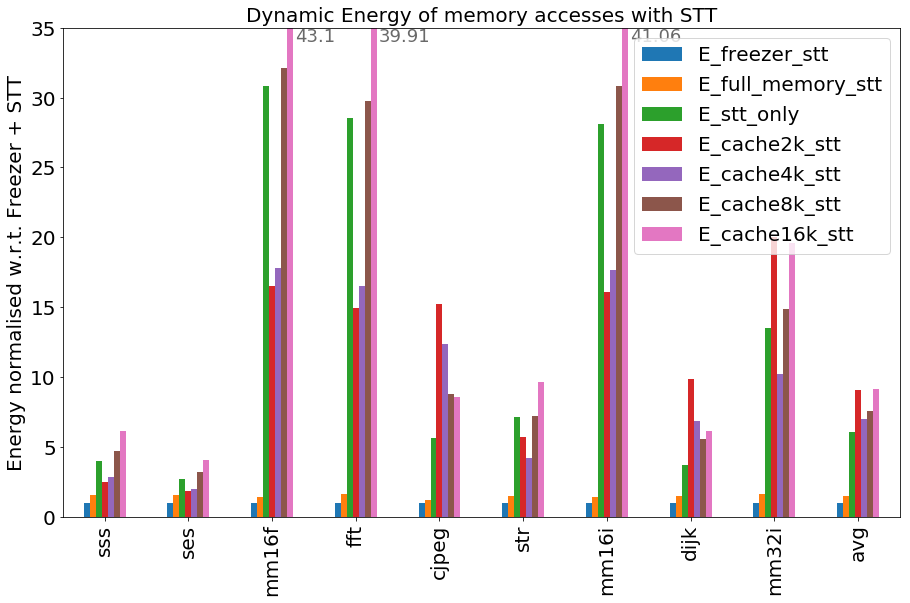

In [48]:
ymax = 35
labels = ['E_freezer_stt', 'E_full_memory_stt', 'E_stt_only','E_cache2k_stt', 'E_cache4k_stt', 'E_cache8k_stt', 'E_cache16k_stt']
cols = [s for s in labels]
ax = comp_df[cols].div(comp_df.E_freezer_stt, axis=0).plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('Dynamic Energy of memory accesses with STT', fontsize=20)
ax.set_ylabel('Energy normalised w.r.t. Freezer + STT', fontsize=20)
ax.legend(labels, prop={'size':20}, loc='upper right')
ax.set_xlabel('')
ax.set_ylim([0,ymax])
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down i.get_height()+
    if i.get_height() > ymax-0.5:
        ax.text(i.get_x()+.1, ymax-1, \
            str(round(i.get_height(),2)), fontsize=18, color='dimgrey')

## STT Aggressive NVM

STT-Aggressive is a more optimised STT cell configuration for NVSim

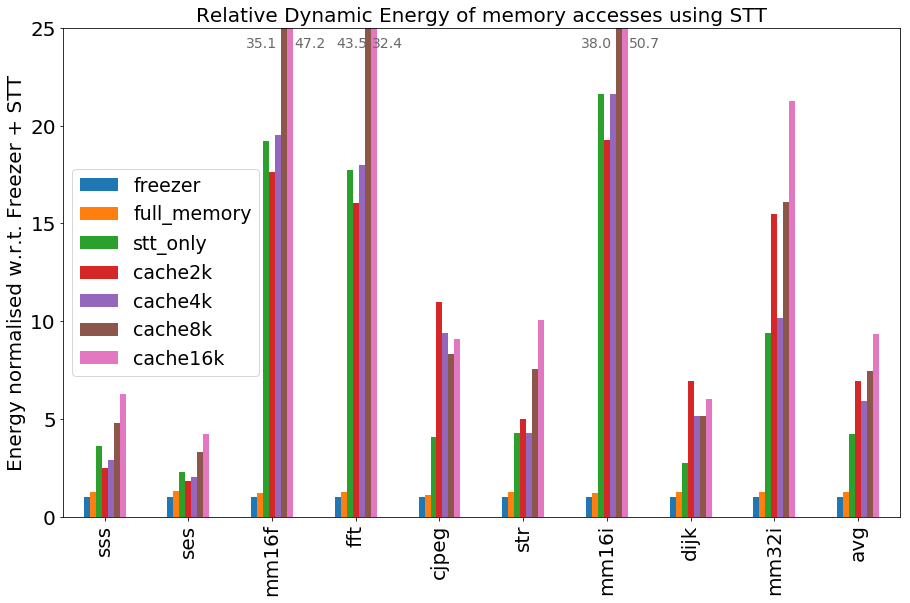

In [49]:
ymax = 25
labels = ['freezer', 'full_memory', 'stt_only', 'cache2k', 'cache4k', 'cache8k', 'cache16k']
cols = [c.format('stt_aggressive') for c in comp_cols]
ax = comp_df[cols].div(comp_df.E_freezer_stt_aggressive, axis=0).plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('Relative Dynamic Energy of memory accesses using STT', fontsize=20)
ax.set_ylabel('Energy normalised w.r.t. Freezer + STT', fontsize=20)
ax.legend(labels, prop={'size':19}, loc='center left')
ax.set_xlabel('')
ax.set_ylim([0,ymax])
r = -0.45
for rect in ax.patches:
    # get_width pulls left or right; get_y pushes up or down i.get_height()+
    y = rect.get_height()
    x = (rect.get_x() + rect.get_width() / 2)
    if y > ymax-0.25:
        ax.text(x+r, ymax-1, str(round(rect.get_height(),1)), fontsize=14, color='dimgrey')
        r = .05 if r<0 else -.45

In [50]:
1-(comp_df.E_freezer_stt_aggressive / comp_df.E_full_memory_stt_aggressive)

Trace
sss      0.208023
ses      0.237305
mm16f    0.170786
fft      0.224977
cjpeg    0.106782
str      0.205721
mm16i    0.190912
dijk     0.208657
mm32i    0.223099
avg      0.205182
dtype: float64

In [51]:
(comp_df.E_stt_aggressive_only / comp_df.E_full_memory_stt_aggressive)

Trace
sss       2.865928
ses       1.746623
mm16f    15.941380
fft      13.739984
cjpeg     3.659412
str       3.426255
mm16i    17.505669
dijk      2.198879
mm32i     7.306031
avg       3.356163
dtype: float64

## RRAM NVM

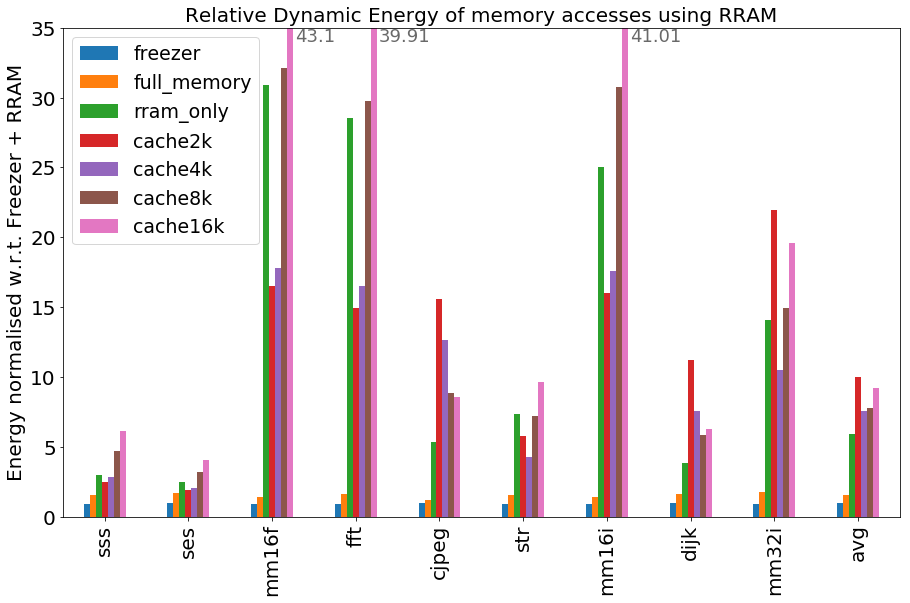

In [52]:
ymax=35
#labels = ['E_freezer', 'E_full_memory', 'E_rram_only','E_cache2k', 'E_cache4k', 'E_cache8k', 'E_cache16k']
labels = ['freezer', 'full_memory', 'rram_only', 'cache2k', 'cache4k', 'cache8k', 'cache16k']
ax = comp_df[[c.format('rram') for c in comp_cols]].div(comp_df.E_freezer_stt, axis=0).plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('Relative Dynamic Energy of memory accesses using RRAM', fontsize=20)
ax.set_ylabel('Energy normalised w.r.t. Freezer + RRAM', fontsize=20)
ax.legend(labels, prop={'size':19}, loc='upper left')
ax.set_xlabel('')
ax.set_ylim([0,ymax])
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down i.get_height()+
    if i.get_height() > ymax:
        ax.text(i.get_x()+.1, ymax-1, \
            str(round(i.get_height(),2)), fontsize=18, color='dimgrey')

In [53]:
(comp_df.E_full_memory_rram / comp_df.E_freezer_rram)

Trace
sss      1.659408
ses      1.767328
mm16f    1.537114
fft      1.780063
cjpeg    1.269678
str      1.634247
mm16i    1.525535
dijk     1.670388
mm32i    1.858865
avg      1.653592
dtype: float64

In [54]:
(comp_df.E_rram_only / comp_df.E_full_memory_rram)

Trace
sss       1.915300
ses       1.458492
mm16f    21.221374
fft      17.385201
cjpeg     4.313939
str       4.767713
mm16i    17.851639
dijk      2.367503
mm32i     7.957891
avg       3.743087
dtype: float64

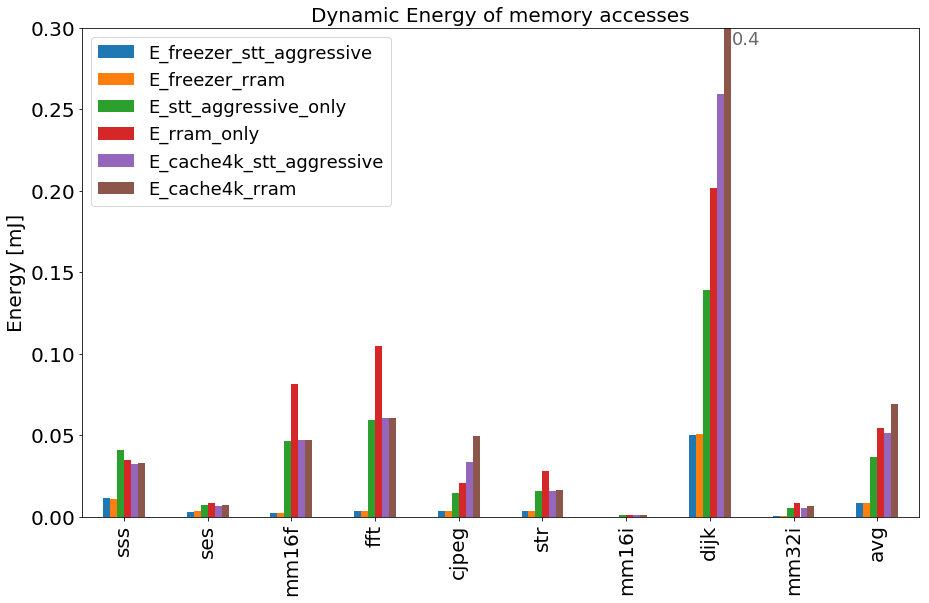

In [55]:
ymax=0.30
comp_c = ['E_freezer_stt_aggressive', 'E_freezer_rram', 'E_stt_aggressive_only', 'E_rram_only', 'E_cache4k_stt_aggressive', 'E_cache4k_rram']
ax = (comp_df[comp_c] * 1e-9).plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('Dynamic Energy of memory accesses', fontsize=20)
ax.set_ylabel('Energy [mJ]', fontsize=20)
ax.legend(prop={'size':18}, loc='upper left')
ax.set_xlabel('')
ax.set_ylim([0,ymax])
for i in ax.patches:
    #get_width pulls left or right; get_y pushes up or down i.get_height()+
    if i.get_height() > ymax:
        ax.text(i.get_x()+.1, ymax-0.01, \
            str(round(i.get_height(),2)), fontsize=18, color='dimgrey')

In [56]:
comp_df['E_program']/(comp_df.E_leakage_sram + comp_df.E_leakage_stt_aggressive)

Trace
sss      0.054430
ses      0.054874
mm16f    0.043989
fft      0.030721
cjpeg    0.080877
str      0.053485
mm16i    0.037459
dijk     0.069640
mm32i    0.061866
avg      0.061691
dtype: float64

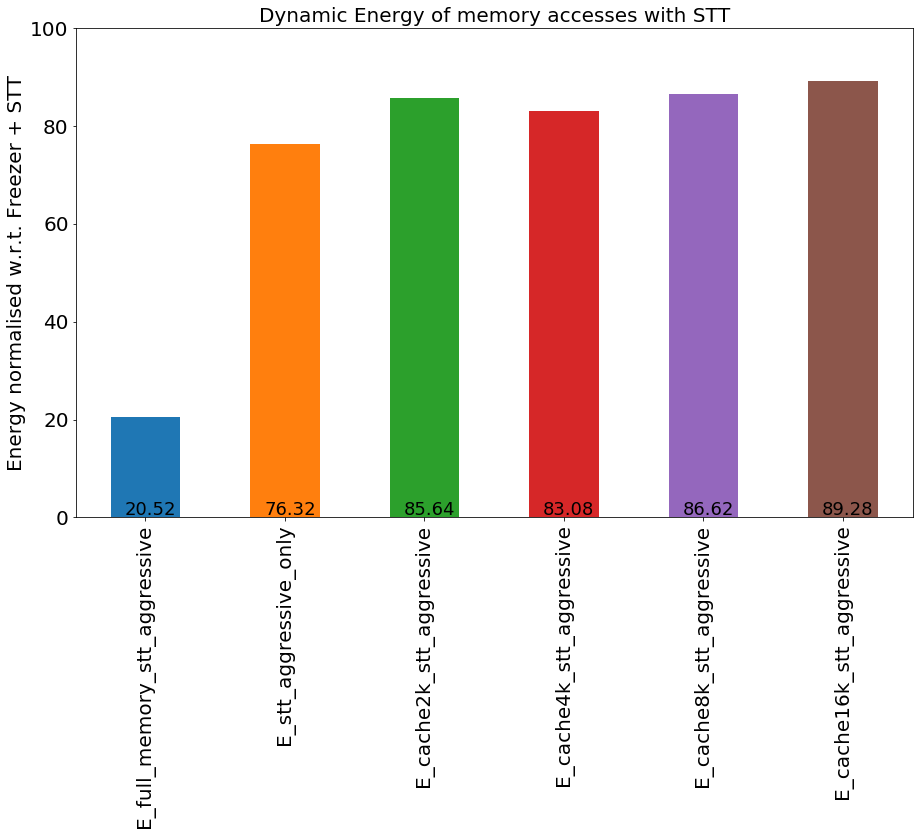

In [57]:
ymax=100
cols = [c.format('stt_aggressive') for c in comp_cols]
labels = [c.replace('_aggressive', '') for c in cols]
tmp = (1-1/comp_df[cols[1:]].loc['avg'].div(comp_df.loc['avg', 'E_freezer_stt_aggressive'], axis=0))*100
ax = tmp.plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('Dynamic Energy of memory accesses with STT', fontsize=20)
ax.set_ylabel('Energy normalised w.r.t. Freezer + STT', fontsize=20)
ax.set_xlabel('')
ax.set_ylim([0,ymax])
for i in ax.patches:
    #get_width pulls left or right; get_y pushes up or down i.get_height()+
    #if i.get_height() > ymax:
    ax.text(i.get_x()+.1, 0.5, \
            str(round(i.get_height(),2)), fontsize=18, color='black')

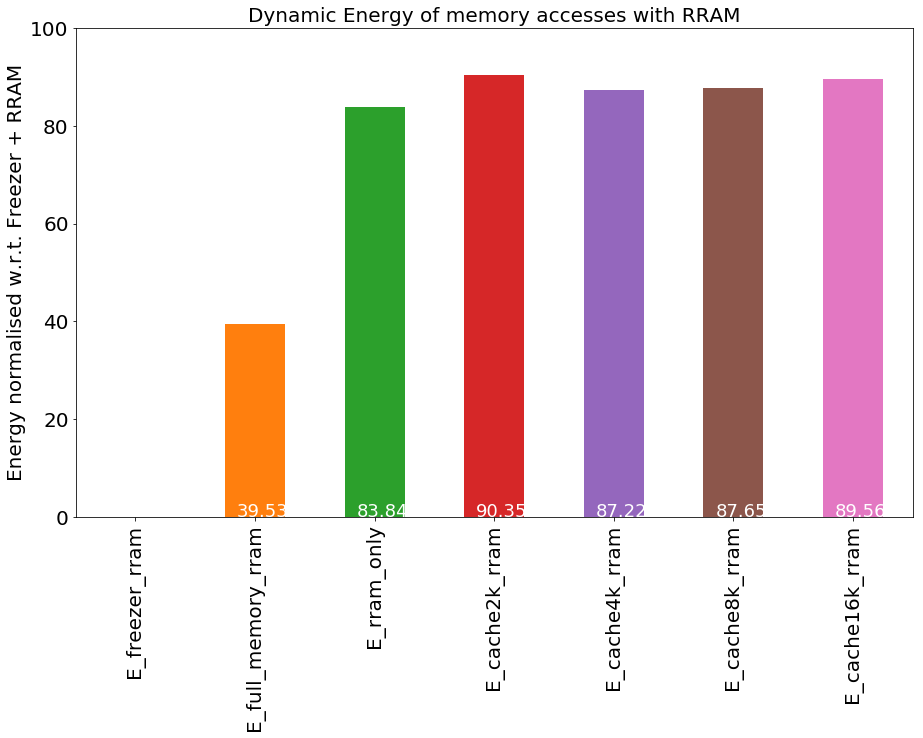

In [58]:
ymax=100
cols = [c.format('rram') for c in comp_cols]
labels = [c for c in cols]
tmp = (1 - 1 / comp_df[cols[1:]].loc['avg'].div(comp_df.loc['avg', 'E_freezer_rram'], axis=0)) * 100
ax = tmp.plot.bar(figsize=(15,9), fontsize=20)
ax.set_title('Dynamic Energy of memory accesses with RRAM', fontsize=20)
ax.set_ylabel('Energy normalised w.r.t. Freezer + RRAM', fontsize=20)
ax.set_xlabel('')
ax.set_ylim([0,ymax])
for i in ax.patches:
    #get_width pulls left or right; get_y pushes up or down i.get_height()+
    #if i.get_height() > ymax:
    ax.text(i.get_x()+.1, 0.125, \
            str(round(i.get_height(),2)), fontsize=18, color='white')

In [59]:
comp_df

freezer_avg_backup_size  freezer_tot_backup_size  num_intervals  \
Trace                                                                    
sss                 223.314286              7816.000000      35.000000   
ses                2638.666667             15832.000000       6.000000   
mm16f               433.371429             15168.000000      35.000000   
fft                 286.349206             18040.000000      63.000000   
cjpeg              3165.000000             25320.000000       8.000000   
str                 751.333333              9016.000000      12.000000   
mm16i               400.000000               800.000000       2.000000   
dijk               1897.473684            144208.000000      76.000000   
mm32i               550.400000              2752.000000       5.000000   
avg                1149.545401             26550.222222      26.888889   

           mem_size     E_program          E_LD          E_ST  E_leakage_sram  \
Trace                                                                           
sss     8192.000000  8.668992e+06  8.465244e+06  2.037485e+05    6.083990e+06   
ses    16384.000000  2.056106e+06  1.881675e+06  1.744313e+05    1.909690e+06   
mm16f   2048.000000  1.751878e+06  1.203938e+06  5.479402e+05    2.029447e+06   
fft     2048.000000  2.253482e+06  1.551336e+06  7.021456e+05    3.737968e+06   
cjpeg   8192.000000  2.728668e+06  2.064981e+06  6.636870e+05    1.288784e+06   
str     8192.000000  2.699005e+06  1.602467e+06  1.096538e+06    1.927643e+06   
mm16i   1024.000000  2.328948e+04  1.824708e+04  5.042397e+03    2.848330e+04   
dijk   16384.000000  3.652315e+07  3.069609e+07  5.827056e+06    2.672947e+07   
mm32i   4096.000000  3.870446e+05  3.404938e+05  4.655072e+04    4.091710e+05   
avg     7395.555556  6.343512e+06  5.313830e+06  1.029682e+06    4.904961e+06   

       E_cache_hits_2048_stt  E_cache_misses_2048_stt      ...       \
Trace                                                      ...        
sss             2.694983e+07             1.974485e+06      ...        
ses             4.854967e+06             1.505709e+06      ...        
mm16f           4.092347e+07             2.745670e+06      ...        
fft             5.258946e+07             2.240538e+06      ...        
cjpeg           1.015764e+07             4.963008e+07      ...        
str             1.293496e+07             9.153774e+06      ...        
mm16i           8.232420e+05             7.001455e+04      ...        
dijk            9.036589e+07             4.287731e+08      ...        
mm32i           4.195561e+06             8.037359e+06      ...        
avg             2.708834e+07             5.601453e+07      ...        

       E_cache_hits_16384_rram  E_cache_misses_16384_rram  \
Trace                                                       
sss               7.061327e+07               1.589197e+05   
ses               1.298385e+07               9.357900e+05   
mm16f             1.137910e+08               3.188856e+04   
fft               1.461098e+08               5.115739e+04   
cjpeg             3.061353e+07               3.142080e+06   
str               3.675334e+07               3.040998e+05   
mm16i             2.261428e+06               1.002120e+04   
dijk              2.659025e+08               6.325630e+07   
mm32i             1.191776e+07               3.412212e+04   
avg               7.677184e+07               7.547153e+06   

       E_cache_flushes_16384_rram  E_cache16k_rram  E_freezer_rram  \
Trace                                                                
sss                 194592.640000     7.096678e+07    1.092932e+07   
ses                  51132.000000     1.397078e+07    3.339924e+06   
mm16f               111598.840000     1.139345e+08    2.501678e+06   
fft                 194137.848000     1.463551e+08    3.382890e+06   
cjpeg                65338.752000     3.382095e+07    3.853419e+06   
str                  59036.416000     3.711648e+07    3.637703e+06   

## Leackage

In [60]:
tmp = comp_df[[ 'mem_size', 'E_freezer_rram', 'E_freezer_stt_aggressive', 'E_leakage_sram', 'E_leakage_stt_aggressive', 'E_leakage_rram']].iloc[:-1]
tmp['E_freezer_rram'] = tmp['E_freezer_rram']
tmp['E_freezer_stt_aggressive'] = tmp['E_freezer_stt_aggressive']
tmp

mem_size  E_freezer_rram  E_freezer_stt_aggressive  E_leakage_sram  \
Trace                                                                       
sss      8192.0    1.092932e+07              1.130747e+07    6.083990e+06   
ses     16384.0    3.339924e+06              3.176792e+06    1.909690e+06   
mm16f    2048.0    2.501678e+06              2.413736e+06    2.029447e+06   
fft      2048.0    3.382890e+06              3.363345e+06    3.737968e+06   
cjpeg    8192.0    3.853419e+06              3.582357e+06    1.288784e+06   
str      8192.0    3.637703e+06              3.671102e+06    1.927643e+06   
mm16i    1024.0    5.121805e+04              4.499917e+04    2.848330e+04   
dijk    16384.0    5.103437e+07              5.004337e+07    2.672947e+07   
mm32i    4096.0    5.810910e+05              5.635120e+05    4.091710e+05   

       E_leakage_stt_aggressive  E_leakage_rram  
Trace                                            
sss                1.531857e+08    3.730608e+08  
ses                3.555998e+07    7.942232e+07  
mm16f              3.779635e+07    9.204630e+07  
fft                6.961579e+07    1.695369e+08  
cjpeg              3.244963e+07    7.902621e+07  
str                4.853514e+07    1.182000e+08  
mm16i              5.932560e+05    1.221349e+06  
dijk               4.977244e+08    1.111655e+09  
mm32i              5.846977e+06    1.861519e+07

In [61]:
tmp.iloc[:,1:-2] * 1e-9

E_freezer_rram  E_freezer_stt_aggressive  E_leakage_sram
Trace                                                          
sss          0.010929                  0.011307        0.006084
ses          0.003340                  0.003177        0.001910
mm16f        0.002502                  0.002414        0.002029
fft          0.003383                  0.003363        0.003738
cjpeg        0.003853                  0.003582        0.001289
str          0.003638                  0.003671        0.001928
mm16i        0.000051                  0.000045        0.000028
dijk         0.051034                  0.050043        0.026729
mm32i        0.000581                  0.000564        0.000409

In [62]:
tmp.iloc[:,1:] = tmp.iloc[:,1:] * 1e-9

Text(0, 0.5, 'Energy [mJ]')

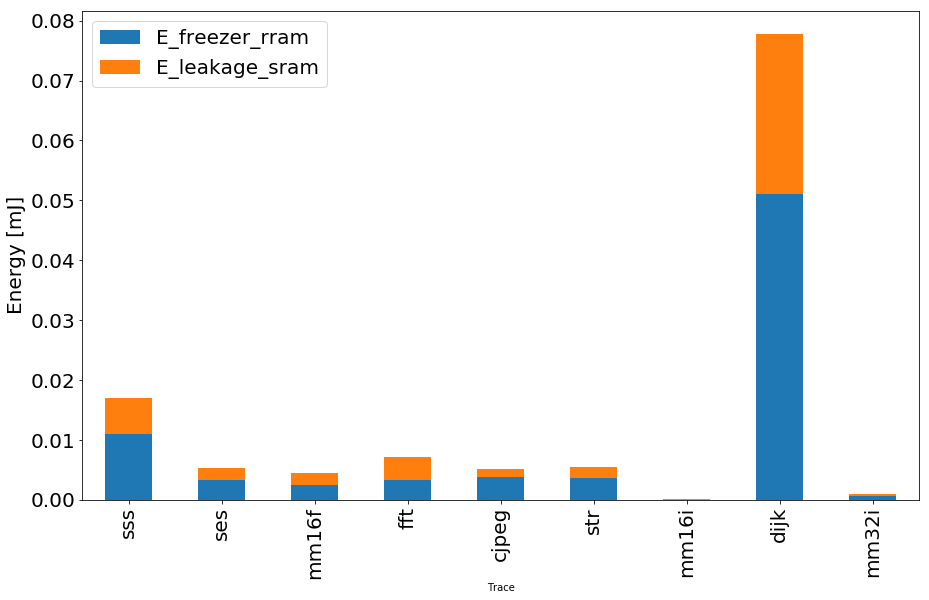

In [65]:
ax = (tmp[['E_freezer_rram', 'E_leakage_sram']]).plot.bar(stacked=True, figsize=(15,9), fontsize=20)
ax.legend(prop={'size':20}, loc='upper left')
ax.set_ylabel('Energy [mJ]', fontsize=20)

Text(0.5, 1.0, 'Energy normalised to freezer_rram')

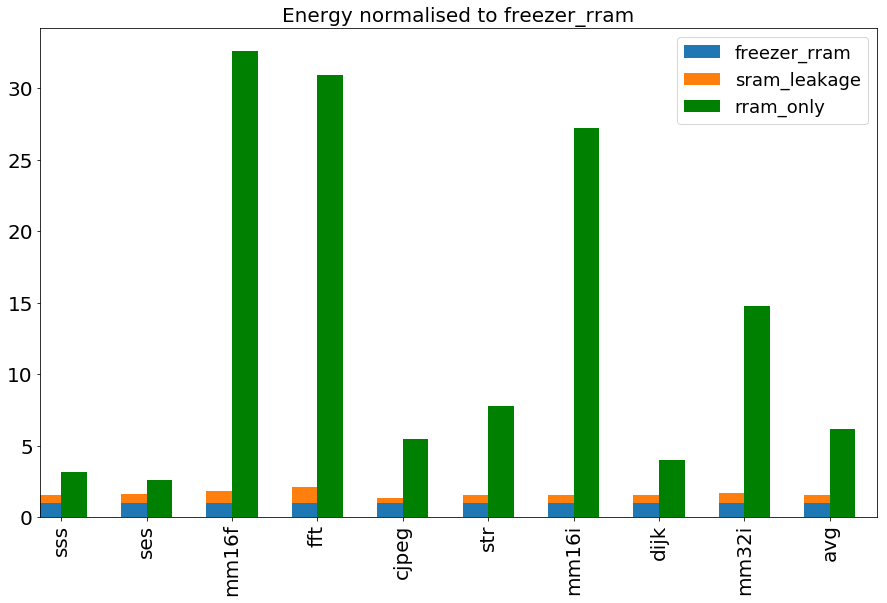

In [66]:
es = (comp_df[['E_freezer_rram', 'E_rram_only', 'E_leakage_sram']] * 1e-9).div(comp_df.E_freezer_rram * 1e-9, axis=0)
ax = es[['E_freezer_rram', 'E_leakage_sram']].plot.bar(stacked=True, figsize=(15,9), fontsize=20, width=-.3, align='edge')
es.E_rram_only.plot.bar(ax=ax, color='green', stacked=False, align='edge', width=.3, fontsize=20)
ax.legend(['freezer_rram', 'sram_leakage', 'rram_only'], prop={'size':18}, loc='upper right')
ax.set_xlabel('')
ax.set_title('Energy normalised to freezer_rram', fontsize=20)

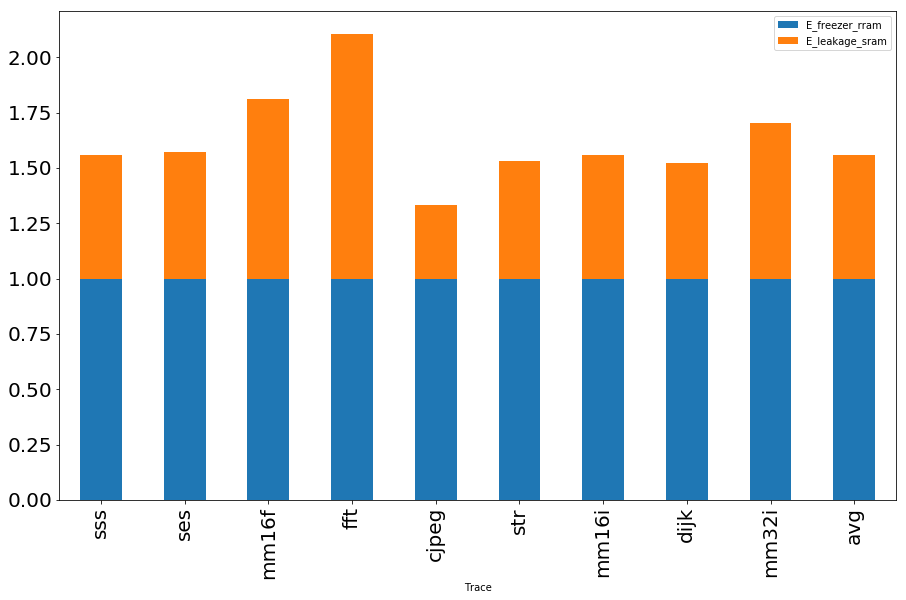

In [67]:
ax = es[['E_freezer_rram', 'E_leakage_sram']].plot.bar(stacked=True, figsize=(15,9), fontsize=20)

In [68]:
comp_df

freezer_avg_backup_size  freezer_tot_backup_size  num_intervals  \
Trace                                                                    
sss                 223.314286              7816.000000      35.000000   
ses                2638.666667             15832.000000       6.000000   
mm16f               433.371429             15168.000000      35.000000   
fft                 286.349206             18040.000000      63.000000   
cjpeg              3165.000000             25320.000000       8.000000   
str                 751.333333              9016.000000      12.000000   
mm16i               400.000000               800.000000       2.000000   
dijk               1897.473684            144208.000000      76.000000   
mm32i               550.400000              2752.000000       5.000000   
avg                1149.545401             26550.222222      26.888889   

           mem_size     E_program          E_LD          E_ST  E_leakage_sram  \
Trace                                                                           
sss     8192.000000  8.668992e+06  8.465244e+06  2.037485e+05    6.083990e+06   
ses    16384.000000  2.056106e+06  1.881675e+06  1.744313e+05    1.909690e+06   
mm16f   2048.000000  1.751878e+06  1.203938e+06  5.479402e+05    2.029447e+06   
fft     2048.000000  2.253482e+06  1.551336e+06  7.021456e+05    3.737968e+06   
cjpeg   8192.000000  2.728668e+06  2.064981e+06  6.636870e+05    1.288784e+06   
str     8192.000000  2.699005e+06  1.602467e+06  1.096538e+06    1.927643e+06   
mm16i   1024.000000  2.328948e+04  1.824708e+04  5.042397e+03    2.848330e+04   
dijk   16384.000000  3.652315e+07  3.069609e+07  5.827056e+06    2.672947e+07   
mm32i   4096.000000  3.870446e+05  3.404938e+05  4.655072e+04    4.091710e+05   
avg     7395.555556  6.343512e+06  5.313830e+06  1.029682e+06    4.904961e+06   

       E_cache_hits_2048_stt  E_cache_misses_2048_stt      ...       \
Trace                                                      ...        
sss             2.694983e+07             1.974485e+06      ...        
ses             4.854967e+06             1.505709e+06      ...        
mm16f           4.092347e+07             2.745670e+06      ...        
fft             5.258946e+07             2.240538e+06      ...        
cjpeg           1.015764e+07             4.963008e+07      ...        
str             1.293496e+07             9.153774e+06      ...        
mm16i           8.232420e+05             7.001455e+04      ...        
dijk            9.036589e+07             4.287731e+08      ...        
mm32i           4.195561e+06             8.037359e+06      ...        
avg             2.708834e+07             5.601453e+07      ...        

       E_cache_hits_16384_rram  E_cache_misses_16384_rram  \
Trace                                                       
sss               7.061327e+07               1.589197e+05   
ses               1.298385e+07               9.357900e+05   
mm16f             1.137910e+08               3.188856e+04   
fft               1.461098e+08               5.115739e+04   
cjpeg             3.061353e+07               3.142080e+06   
str               3.675334e+07               3.040998e+05   
mm16i             2.261428e+06               1.002120e+04   
dijk              2.659025e+08               6.325630e+07   
mm32i             1.191776e+07               3.412212e+04   
avg               7.677184e+07               7.547153e+06   

       E_cache_flushes_16384_rram  E_cache16k_rram  E_freezer_rram  \
Trace                                                                
sss                 194592.640000     7.096678e+07    1.092932e+07   
ses                  51132.000000     1.397078e+07    3.339924e+06   
mm16f               111598.840000     1.139345e+08    2.501678e+06   
fft                 194137.848000     1.463551e+08    3.382890e+06   
cjpeg                65338.752000     3.382095e+07    3.853419e+06   
str                  59036.416000     3.711648e+07    3.637703e+06   

### Freezer total enerergy decomposition (RRAM)

Text(0, 0.5, '')

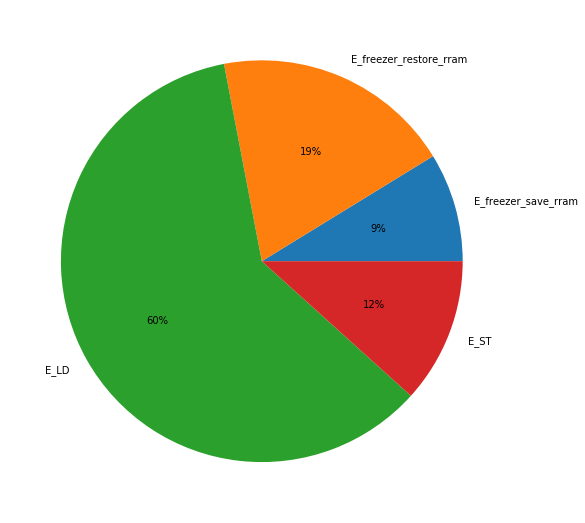

In [69]:
E_freezer_rram_backup_rest = comp_df.E_freezer_rram - comp_df.E_program
comp_df['E_freezer_b/r_rram'] = E_freezer_rram_backup_rest
ax = comp_df.loc['avg',
            ['E_freezer_save_rram',
             'E_freezer_restore_rram', 
             'E_LD',
             'E_ST']
           ].plot.pie(figsize=(9,15), autopct='%1.0f%%')
ax.set_ylabel('')

## Freezer energy decomposition (STT)

Text(0, 0.5, '')

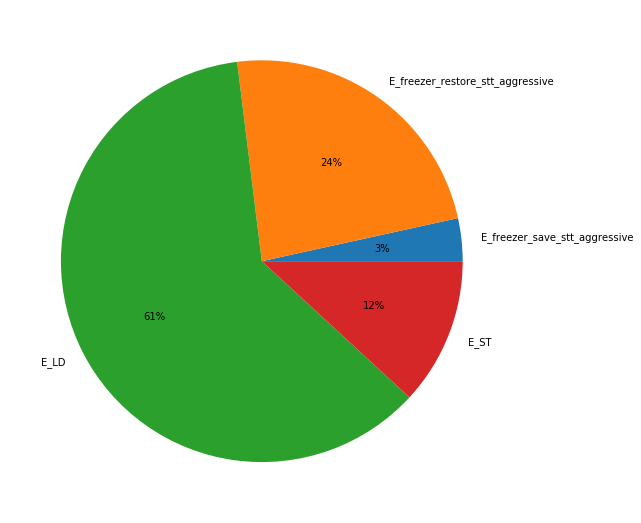

In [71]:
E_freezer_stt_backup_rest = comp_df.E_freezer_stt_aggressive - comp_df.E_program
comp_df['E_freezer_b/r_stt'] = E_freezer_stt_backup_rest
ax = comp_df \
    .loc['avg', 
         ['E_freezer_save_stt_aggressive',
          'E_freezer_restore_stt_aggressive', 
          'E_LD',
          'E_ST']
        ].plot.pie(figsize=(9,15), autopct='%1.0f%%')
ax.set_ylabel('')

## Full-memory backup/restore energy decomposition (STT)

Text(0, 0.5, '')

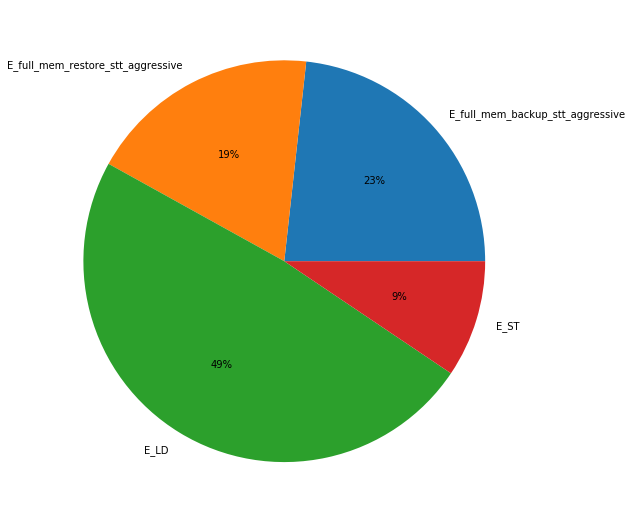

In [73]:
E_fullmem_stt_backup_rest = comp_df.E_full_memory_stt_aggressive - comp_df.E_program
comp_df['E_full_mem_backup_stt_aggressive'] = E_fullmem_stt_backup_rest - comp_df.E_freezer_restore_stt_aggressive
comp_df['E_full_mem_restore_stt_aggressive'] = comp_df.E_freezer_restore_stt_aggressive
ax = comp_df \
    .loc['avg', 
         ['E_full_mem_backup_stt_aggressive',
          'E_full_mem_restore_stt_aggressive',
          'E_LD',
          'E_ST']
        ].plot.pie(figsize=(9,15), autopct='%1.0f%%')
ax.set_ylabel('')

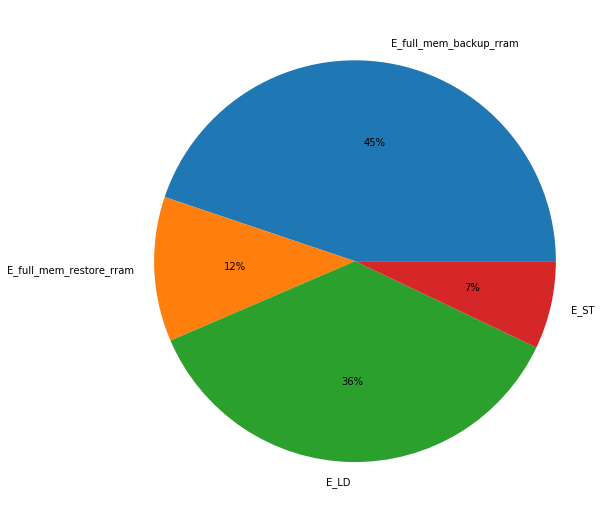

In [75]:
E_fullmem_rram_backup_rest = comp_df.E_full_memory_rram - comp_df.E_program
comp_df['E_full_mem_b/r_rram'] = E_fullmem_rram_backup_rest
comp_df['E_full_mem_backup_rram'] = E_fullmem_rram_backup_rest - comp_df.E_freezer_restore_rram
comp_df['E_full_mem_restore_rram'] = comp_df.E_freezer_restore_rram
ax = comp_df \
    .loc['avg', 
         ['E_full_mem_backup_rram',
          'E_full_mem_restore_rram',
          'E_LD',
          'E_ST']
        ].plot.pie(figsize=(9,15), autopct='%1.0f%%') #, explode=(0.01, 0.01, 0, 0))
ax.set_ylabel('')
ax

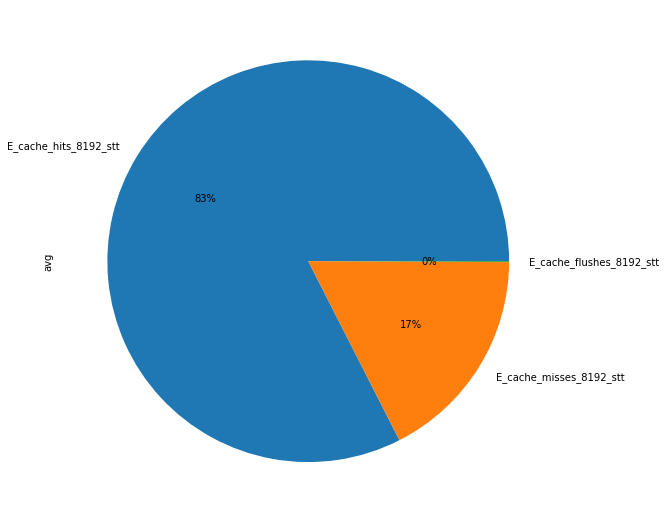

In [76]:
comp_df.loc['avg', ['E_cache_hits_8192_stt', 'E_cache_misses_8192_stt', 'E_cache_flushes_8192_stt']].plot.pie(figsize=(9,15), autopct='%1.0f%%')

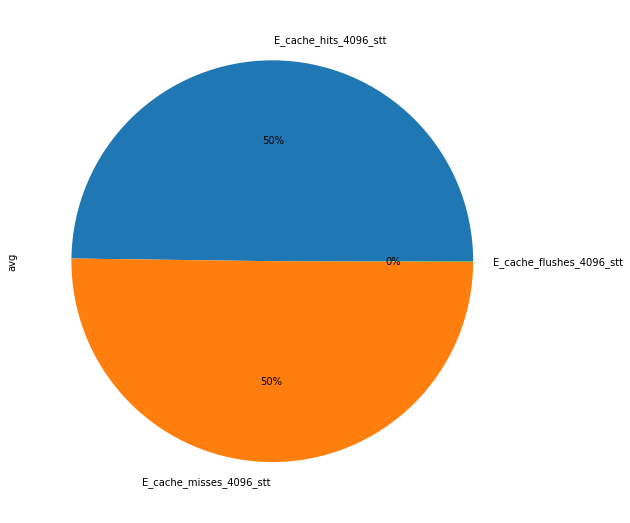

In [77]:
comp_df.loc['avg', ['E_cache_hits_4096_stt', 'E_cache_misses_4096_stt', 'E_cache_flushes_4096_stt']].plot.pie(figsize=(9,15), autopct='%1.0f%%')

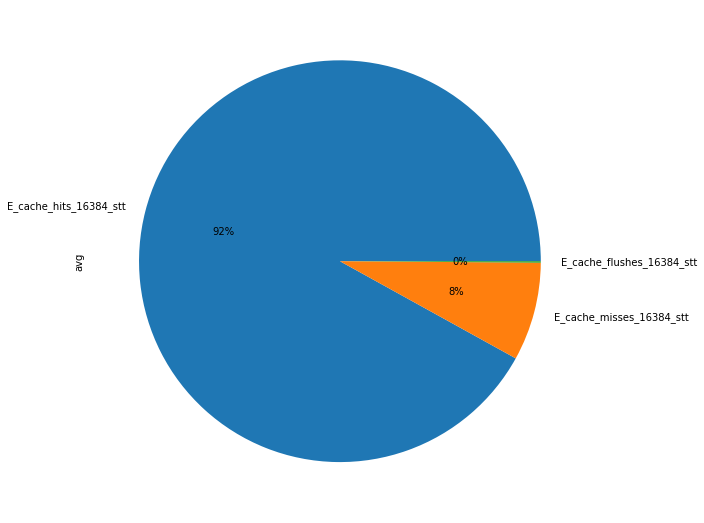

In [78]:
comp_df.loc['avg', ['E_cache_hits_16384_stt', 'E_cache_misses_16384_stt', 'E_cache_flushes_16384_stt']].plot.pie(figsize=(9,15),autopct='%1.0f%%')